   age          job  marital          education default  housing     loan  \
0   30  blue-collar  married           basic.9y      no      yes       no   
1   39     services   single        high.school      no       no       no   
2   25     services  married        high.school      no      yes       no   
3   38     services  married           basic.9y      no  unknown  unknown   
4   47       admin.  married  university.degree      no      yes       no   

     contact month day_of_week  ...  previous     poutcome  emp.var.rate  \
0   cellular   may         fri  ...         0  nonexistent          -1.8   
1  telephone   may         fri  ...         0  nonexistent           1.1   
2  telephone   jun         wed  ...         0  nonexistent           1.4   
3  telephone   jun         fri  ...         0  nonexistent           1.4   
4   cellular   nov         mon  ...         0  nonexistent          -0.1   

   cons.price.idx cons.conf.idx  euribor3m  nr.employed   y  balance  day  
0   

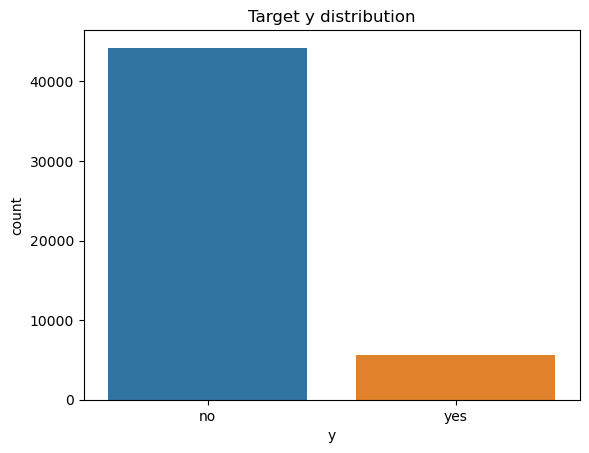

no     44216
yes     5612
Name: y, dtype: int64
Loaded merged_bank_data.csv and displayed head, shape, and target distribution


In [1]:
# Load data, inspect head, and plot target distribution
# This cell imports libraries, reads the CSV, shows a quick preview, and visualizes the target variable distribution.
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from tqdm.auto import tqdm

df_bank = pd.read_csv('C:/Users/hp/Downloads/merged_bank_data.csv', encoding='ascii')
print(df_bank.head())
print(df_bank.shape)

# Plot target distribution if y exists
if 'y' in df_bank.columns:
    counts = df_bank['y'].value_counts(dropna=False)
    sns.countplot(x='y', data=df_bank)
    plt.title('Target y distribution')
    plt.xlabel('y')
    plt.ylabel('count')
    plt.show()
    print(counts)

print('Loaded merged_bank_data.csv and displayed head, shape, and target distribution')

In [2]:
# Prepare features/target, drop leakage column duration, and split train/test with stratification
from sklearn.model_selection import train_test_split
import numpy as np

# Binary target encoding
y_series = df_bank['y'].map({'yes': 1, 'no': 0})

# Drop duration due to leakage for realistic modeling if present
feature_cols = [c for c in df_bank.columns if c not in ['y', 'duration']]
X_df = df_bank[feature_cols].copy()

# Train-test split
X_train, X_test, y_train, y_test = train_test_split(
    X_df, y_series, test_size=0.2, random_state=42, stratify=y_series
)

print(X_train.shape)
print(X_test.shape)
print(y_train.value_counts())
print(y_test.value_counts())
print('Prepared features, dropped duration, and created stratified train/test splits')

(39862, 21)
(9966, 21)
0    35372
1     4490
Name: y, dtype: int64
0    8844
1    1122
Name: y, dtype: int64
Prepared features, dropped duration, and created stratified train/test splits


In [3]:
# Build preprocessing pipeline and train a Decision Tree classifier
# - Impute numeric/categorical
# - One-hot encode categoricals
# - Train a balanced DecisionTree with regularization to avoid overfitting
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder
from sklearn.impute import SimpleImputer
from sklearn.pipeline import Pipeline
from sklearn.tree import DecisionTreeClassifier
from tqdm.auto import tqdm

numeric_cols = X_train.select_dtypes(include=['int64', 'float64']).columns.tolist()
categorical_cols = [c for c in X_train.columns if c not in numeric_cols]

categorical_pipe = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='most_frequent')),
    ('onehot', OneHotEncoder(handle_unknown='ignore'))
])

preprocess = ColumnTransformer(transformers=[
    ('num', SimpleImputer(strategy='median'), numeric_cols),
    ('cat', categorical_pipe, categorical_cols)
])

clf = Pipeline(steps=[
    ('preprocess', preprocess),
    ('model', DecisionTreeClassifier(random_state=42, class_weight='balanced', max_depth=8, min_samples_leaf=50, min_samples_split=100))
])

for _ in tqdm(range(1)):
    clf.fit(X_train, y_train)

model = clf.named_steps['model']
print(model.get_depth())
print(model.get_n_leaves())
print('Trained Decision Tree with preprocessing pipeline')

  0%|          | 0/1 [00:00<?, ?it/s]

8
95
Trained Decision Tree with preprocessing pipeline


In [4]:
# Evaluate on the test set: accuracy, precision, recall, f1, ROC-AUC, and confusion matrix
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score, roc_curve, confusion_matrix, classification_report
import numpy as np
import matplotlib.pyplot as plt

y_prob = clf.predict_proba(X_test)[:, 1]
y_pred = (y_prob >= 0.5).astype(int)

acc = accuracy_score(y_test, y_pred)
prec = precision_score(y_test, y_pred, zero_division=0)
rec = recall_score(y_test, y_pred)
f1 = f1_score(y_test, y_pred)
auc = roc_auc_score(y_test, y_prob)
cm = confusion_matrix(y_test, y_pred)

print(acc)
print(prec)
print(rec)
print(f1)
print(auc)
print(cm)
print(classification_report(y_test, y_pred, digits=3))
print('Computed evaluation metrics on test set')

0.8147702187437287
0.33348666053357867
0.6461675579322638
0.4399271844660194
0.7841172620933576
[[7395 1449]
 [ 397  725]]
              precision    recall  f1-score   support

           0      0.949     0.836     0.889      8844
           1      0.333     0.646     0.440      1122

    accuracy                          0.815      9966
   macro avg      0.641     0.741     0.664      9966
weighted avg      0.880     0.815     0.838      9966

Computed evaluation metrics on test set


              base  importance
21     nr.employed    0.606104
3    cons.conf.idx    0.094960
22           pdays    0.066498
15       euribor3m    0.051281
4   cons.price.idx    0.030984
23        poutcome    0.030411
0              age    0.028904
20           month    0.019426
5          contact    0.019011
17             job    0.008827
19         marital    0.007564
2         campaign    0.007354
13       education    0.006799
1          balance    0.005901
24        previous    0.003489
         base  importance
0         age    0.028904
17        job    0.008827
19    marital    0.007564
13  education    0.006799
18       loan    0.001915
16    housing    0.000214
12    default    0.000000


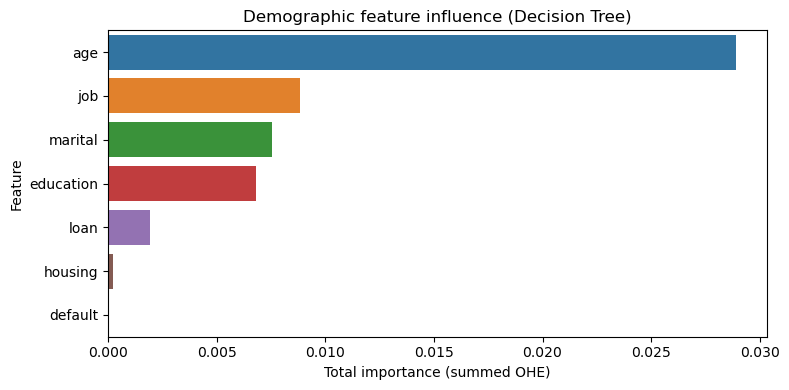

Computed and plotted feature importances with demographic focus


In [5]:
# Extract feature importances for demographic features and display top ones
# We will map one-hot encoded features back to original categories and aggregate by original demographic feature.
import numpy as np
import pandas as pd
from sklearn.preprocessing import OneHotEncoder

pipe = clf
pre = pipe.named_steps['preprocess']
enc = pre.named_transformers_['cat'].named_steps['onehot']
num_cols = pre.transformers_[0][2]
cat_cols = pre.transformers_[1][2]

# Get transformed feature names
cat_feature_names = enc.get_feature_names_out(cat_cols)
all_feature_names = list(num_cols) + list(cat_feature_names)
importances = pipe.named_steps['model'].feature_importances_

# Build dataframe of importances
imp_df = pd.DataFrame({'feature': all_feature_names, 'importance': importances})
# Aggregate by original categorical column by summing its one-hot importances
imp_df['base'] = imp_df['feature'].apply(lambda x: x.split('_')[0] if x.split('_')[0] in cat_cols else x)
agg = imp_df.groupby('base', as_index=False)['importance'].sum().sort_values('importance', ascending=False)

# Define demographic features set (assumption)
demographic_features = ['age','job','marital','education','default','housing','loan']
agg_demo = agg[agg['base'].isin(demographic_features)]

print(agg.head(15))
print(agg_demo)

# Plot top demographic contributors
import seaborn as sns
import matplotlib.pyplot as plt
plt.figure(figsize=(8,4))
sns.barplot(x='importance', y='base', data=agg_demo.sort_values('importance', ascending=False))
plt.title('Demographic feature influence (Decision Tree)')
plt.xlabel('Total importance (summed OHE)')
plt.ylabel('Feature')
plt.tight_layout()
plt.show()

print('Computed and plotted feature importances with demographic focus')

           education  avg_predicted_purchase_prob
9  university.degree                     0.383850
0           basic.4y                     0.382528
1           basic.6y                     0.382528
2           basic.9y                     0.382528
4         illiterate                     0.382528


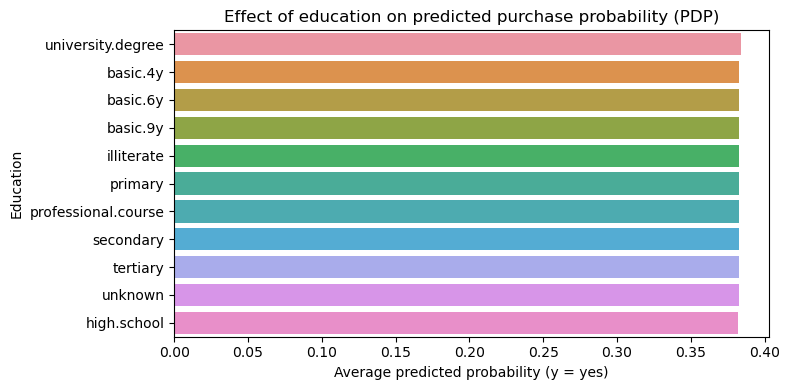

Computed PDP for education on purchase probability and plotted it


In [7]:
# Plot how education modifies purchase probability using Partial Dependence
# We will compute PDP over education categories by averaging predicted proba when setting education to each category.
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# Get unique education categories from training data (including those seen during fit via encoder)
edu_levels = sorted([c for c in X_train['education'].dropna().unique().tolist()])

# Function to compute average predicted probability when forcing education to a given level
probs = []
for lvl in edu_levels:
    X_tmp = X_test.copy()
    X_tmp['education'] = lvl
    p = clf.predict_proba(X_tmp)[:, 1].mean()
    probs.append(p)

edu_pdp = pd.DataFrame({'education': edu_levels, 'avg_predicted_purchase_prob': probs}).sort_values('avg_predicted_purchase_prob', ascending=False)

print(edu_pdp.head())

plt.figure(figsize=(8,4))
sns.barplot(data=edu_pdp, x='avg_predicted_purchase_prob', y='education')
plt.xlabel('Average predicted probability (y = yes)')
plt.ylabel('Education')
plt.title('Effect of education on predicted purchase probability (PDP)')
plt.tight_layout()
plt.show()

print('Computed PDP for education on purchase probability and plotted it')